In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [ ]:
# Kaggle setup (replace with your credentials)
os.environ["KAGGLE_USERNAME"] = "magdhndi"  # Replace with your kaggle username
os.environ["KAGGLE_KEY"] = "9b6c8953fb75d807a407f863ae22edc6"  # Replace with your kaggle key

# Download and unzip dataset
!kaggle datasets download andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k


In [3]:
# Data loading and preprocessing (same as before)
df = pd.read_csv("/content/full_df.csv")

In [11]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0


def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))

    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))

    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))

    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))

    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))

    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values

    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values

    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values

    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);

    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [12]:
normal, cataract, diab, glaucoma, hyper, myopia, age, other = process_dataset(df)


#TO BE CONTINUE

In [16]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm

dataset_dir = "/content/preprocessed_images"
image_size = 224
labels = []
dataset = []

def create_dataset(image_category, label, max=5000):
    """Load and resize images, then add them to the dataset with their labels."""
    dataset = []
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            # Load and resize the image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is None:
                print(f"Unable to read image: {image_path}")
                continue
            image = cv2.resize(image, (image_size, image_size))
            dataset.append([np.array(image), np.array(label)])
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

    # Shuffle the dataset
    random.shuffle(dataset)
    return dataset

def apply_red_free_filter(image):
    """Apply red-free filter to enhance contrast of blood vessels."""
    green_channel = image[:, :, 1]  # Extract the green channel
    return cv2.merge([green_channel, green_channel, green_channel])

def apply_fluorescein_angiography(image):
    """Simulate fluorescein angiography by altering brightness and contrast."""
    alpha = 1.5  # Contrast control (1.0-3.0)
    beta = 50    # Brightness control (0-100)
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def apply_diab_filters(dataset):
    """Apply diabetic retinopathy filters to the dataset."""
    filtered_dataset = []
    for data in dataset:
        image, label = data
        try:
            # Apply filters sequentially
            image_red_free = apply_red_free_filter(image)
            image_fluorescein = apply_fluorescein_angiography(image_red_free)
            filtered_dataset.append([np.array(image_fluorescein), label])
        except Exception as e:
            print(f"Error applying filters to image: {e}")
            continue
    return filtered_dataset


In [18]:
diab_dataset = create_dataset(diab, 1)
len(diab_dataset)

  2%|▏         | 38/1818 [00:00<00:04, 372.43it/s]

Unable to read image: /content/preprocessed_images/2_left.jpg
Unable to read image: /content/preprocessed_images/50_left.jpg
Unable to read image: /content/preprocessed_images/74_left.jpg
Unable to read image: /content/preprocessed_images/90_left.jpg
Unable to read image: /content/preprocessed_images/195_left.jpg
Unable to read image: /content/preprocessed_images/201_left.jpg
Unable to read image: /content/preprocessed_images/224_left.jpg
Unable to read image: /content/preprocessed_images/342_left.jpg
Unable to read image: /content/preprocessed_images/361_left.jpg
Unable to read image: /content/preprocessed_images/497_left.jpg


  6%|▌         | 112/1818 [00:00<00:04, 346.10it/s]

Unable to read image: /content/preprocessed_images/516_left.jpg
Unable to read image: /content/preprocessed_images/592_left.jpg
Unable to read image: /content/preprocessed_images/612_left.jpg
Unable to read image: /content/preprocessed_images/795_left.jpg
Unable to read image: /content/preprocessed_images/819_left.jpg
Unable to read image: /content/preprocessed_images/905_left.jpg


 12%|█▏        | 215/1818 [00:00<00:04, 332.04it/s]

Unable to read image: /content/preprocessed_images/993_left.jpg


 78%|███████▊  | 1420/1818 [00:03<00:00, 540.03it/s]

Unable to read image: /content/preprocessed_images/22_right.jpg
Unable to read image: /content/preprocessed_images/41_right.jpg
Unable to read image: /content/preprocessed_images/202_right.jpg
Unable to read image: /content/preprocessed_images/328_right.jpg
Unable to read image: /content/preprocessed_images/467_right.jpg
Unable to read image: /content/preprocessed_images/595_right.jpg
Unable to read image: /content/preprocessed_images/600_right.jpg


 87%|████████▋ | 1583/1818 [00:03<00:00, 531.48it/s]

Unable to read image: /content/preprocessed_images/914_right.jpg
Unable to read image: /content/preprocessed_images/920_right.jpg
Unable to read image: /content/preprocessed_images/1965_right.jpg
Unable to read image: /content/preprocessed_images/4091_right.jpg


 96%|█████████▌| 1742/1818 [00:03<00:00, 513.26it/s]

Unable to read image: /content/preprocessed_images/4243_right.jpg


100%|██████████| 1818/1818 [00:03<00:00, 459.67it/s]


1789

In [19]:
processed_dataset = apply_diab_filters(diab_dataset)

In [20]:
len(processed_dataset)

1789

In [21]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 700/700 [00:01<00:00, 518.99it/s]


700

In [22]:
processed_dataset_normal = apply_diab_filters(dataset)

In [23]:
processed_dataset += processed_dataset_normal

In [ ]:
dataset = create_dataset(cataract,0)
dataset = create_dataset(diab,0)
#dataset = create_dataset(hyper,0)
dataset = create_dataset(myopia,0)
dataset = create_dataset(age,0)
len(dataset)

100%|██████████| 551/551 [00:01<00:00, 419.95it/s]


5081

In [26]:
dataset = processed_dataset
dataset += processed_dataset_normal
len(dataset)

3189

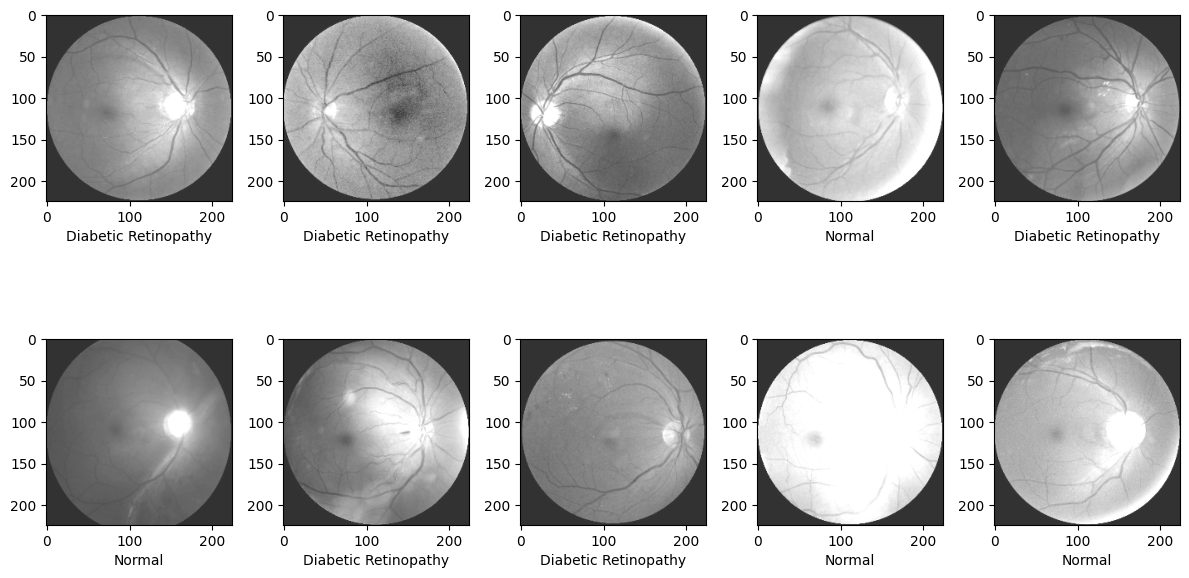

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Diabetic Retinopathy"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [29]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])
dataset = 0

In [30]:
processed_dataset = 0;
processed_dataset_normal = 0;

In [31]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x, y = 0,0

In [32]:
from tensorflow.keras.applications.resnet50 import ResNet50
rnet = ResNet50(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
for layer in rnet.layers:
    layer.trainable = False


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model2 = Sequential()
model2.add(rnet)
model2.add(Flatten())
model2.add(Dense(1,activation="sigmoid"))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         100,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [34]:
model2.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# Replace 'period' with 'save_freq'
checkpoint = ModelCheckpoint("rnet50.keras",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq=1)

earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1, mode='max')

In [35]:
history2 = model2.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
 3/80 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5330 - loss: 6.6910

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:199: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - accuracy: 0.5912 - loss: 2.9754 - val_accuracy: 0.8088 - val_loss: 0.5526
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.8663 - loss: 0.3750 - val_accuracy: 0.7712 - val_loss: 0.7928
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.9023 - loss: 0.2491 - val_accuracy: 0.9263 - val_loss: 0.2795
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9792 - loss: 0.0593 - val_accuracy: 0.9342 - val_loss: 0.2584
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.9953 - loss: 0.0215 - val_accuracy: 0.9436 - val_loss: 0.2099
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9965 - loss: 0.0203 - val_accuracy: 0.9420 - val_loss: 0.2605
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9966 - loss: 0.0179 - val_accuracy: 0.9451 - val_loss: 0.2310
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9963 - loss: 0.0102 - val_accuracy: 0.9436 - val_loss: 0.2029
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9997 - loss: 0.0035 - val_accuracy: 0.9342 - va

#TO Be Continue 2


In [36]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
model2.save('/content/drive/MyDrive/F5_project/diabetic_model_wiht_filter.keras')

In [ ]:
glaucoma_model_wiht_filter = load_model('/content/drive/MyDrive/F5_project/glaucoma_model_wiht_filter.keras')


In [39]:
loss,accuracy = model2.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9439 - loss: 0.2447
loss: 0.2201162427663803
Accuracy: 0.9435736536979675


In [ ]:
import pandas as pd
import os
import numpy as np

def save_results_to_csv(y_data, y_pred, filename='Glaucoma_result.csv'):
    # Ensure y_data and y_pred are flattened to 1D arrays
    y_data_flat = np.ravel(y_data)
    y_pred_flat = np.ravel(y_pred)

    # Create a DataFrame from y_data and y_pred
    results_df = pd.DataFrame({
        'y_data': y_data_flat,
        'y_pred': y_pred_flat
    })

    # Check if the file already exists
    if os.path.exists(filename):
        # Append data to the existing CSV file
        results_df.to_csv(filename, mode='a', header=False, index=False)
    else:
        # Create a new CSV file with headers
        results_df.to_csv(filename, mode='w', header=True, index=False)

# Example usage:
# save_results_to_csv(y_test, y_pred_test)


In [ ]:
y_pred_test = glaucoma_model_3.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 194s 6s/step


In [ ]:
# Example usage:
save_results_to_csv(y_test, y_pred_test)

In [ ]:
# Data loading and preprocessing (same as before)
data_glu = pd.read_csv("/content/Glaucoma_result.csv")

In [ ]:
len(data_glu)

5081

In [ ]:
y_pred_train = model2.predict(x_train)

73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step


In [ ]:
# Example usage:
save_results_to_csv(y_train, y_pred_train, filename="/content/Glaucoma_result.csv")

In [ ]:
 y_2 = (y_pred_train > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

print(classification_report(y_train, y_2))  # Use y_data directly


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1118
           1       1.00      1.00      1.00      1195

    accuracy                           1.00      2313
   macro avg       1.00      1.00      1.00      2313
weighted avg       1.00      1.00      1.00      2313



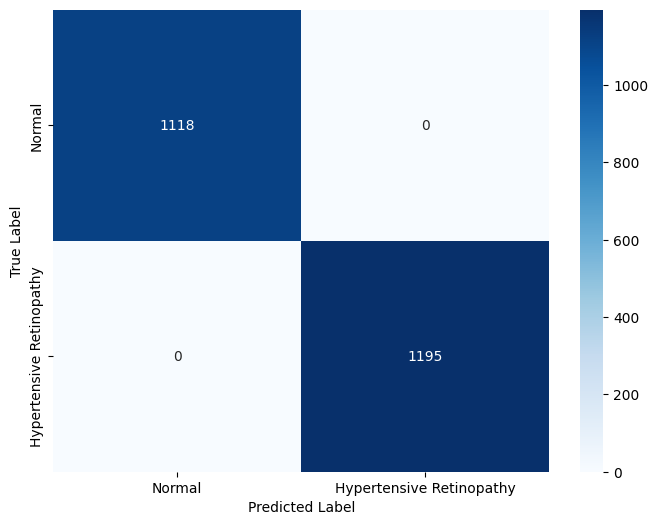

In [ ]:
cm = confusion_matrix(y_train, y_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Hypertensive Retinopathy"], yticklabels=["Normal", "Hypertensive Retinopathy"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Evaluation and Analysis
def evaluate_model(model, x_data, y_data, set_name):
    """Evaluates the model and prints classification report and confusion matrix."""

    y_pred = model.predict(x_data)  # Get predictions for the given data
    y_pred = (y_pred > 0.99).astype(int).flatten()  # Convert probabilities to binary predictions

    print(f"\n--- {set_name} Set Evaluation ---")
    print(classification_report(y_data, y_pred))  # Use y_data directly

    cm = confusion_matrix(y_data, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Glaucoma"], yticklabels=["Normal", "Glaucoma"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {set_name}")
    plt.show()

    return y_data, y_pred, cm



32/32 ━━━━━━━━━━━━━━━━━━━━ 193s 6s/step

--- Training Set Evaluation ---
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       897
           1       0.57      1.00      0.73       120

    accuracy                           0.91      1017
   macro avg       0.78      0.95      0.84      1017
weighted avg       0.95      0.91      0.92      1017



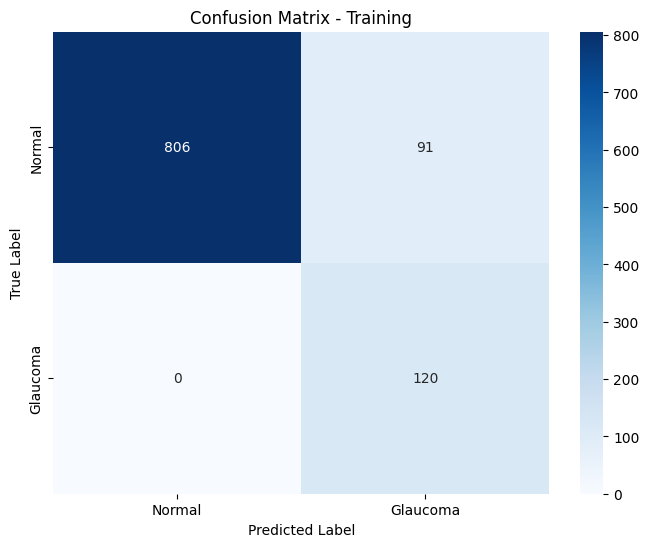

In [ ]:
# Evaluate on training, validation, and test sets 0.95
train_true, train_pred, train_cm = evaluate_model(glaucoma_model_3, x_test, y_test, "Training")

34/34 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step

--- Training Set Evaluation ---
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       956
           1       0.50      0.98      0.66       124

    accuracy                           0.89      1080
   macro avg       0.75      0.93      0.80      1080
weighted avg       0.94      0.89      0.90      1080



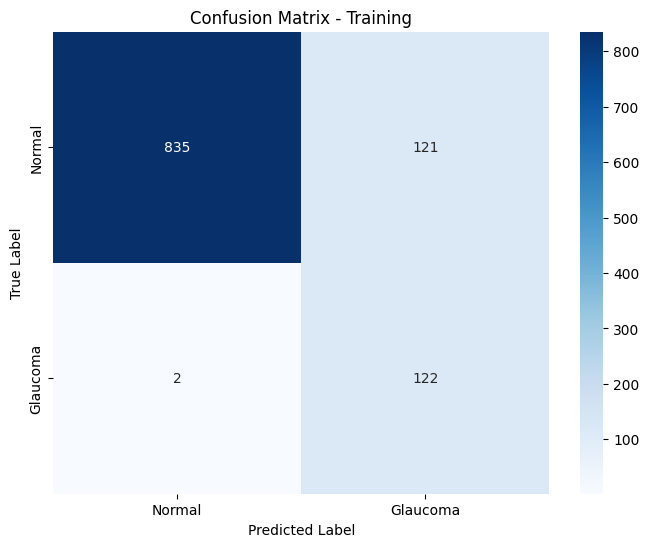

In [ ]:
# Evaluate on training, validation, and test sets 0.9
train_true, train_pred, train_cm = evaluate_model(glaucoma_model_3, x_test, y_test, "Training")

34/34 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step

--- Training Set Evaluation ---
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       956
           1       0.42      0.99      0.59       124

    accuracy                           0.84      1080
   macro avg       0.71      0.91      0.75      1080
weighted avg       0.93      0.84      0.87      1080



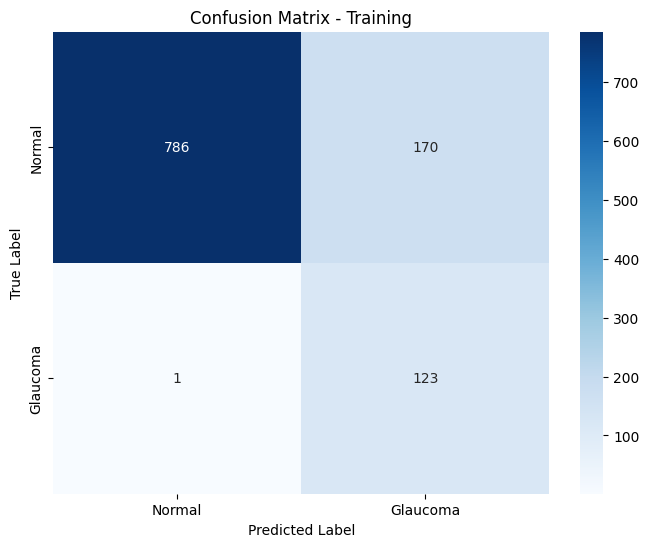

In [ ]:
# Evaluate on training, validation, and test sets 0.7
train_true, train_pred, train_cm = evaluate_model(glaucoma_model_3, x_test, y_test, "Training")